In [2]:
import os
import cv2
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from skimage import io
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [3]:
!conda install -y gdown

Solving environment: done

# All requested packages already installed.



In [4]:
!gdown --id 1QpE9BsuD6MVmMzCBLIInstHcWGP5Z5OO

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QpE9BsuD6MVmMzCBLIInstHcWGP5Z5OO
To: /kaggle/working/assndl.zip
100%|███████████████████████████████████████| 1.84G/1.84G [00:06<00:00, 270MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("./assndl.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [114]:
img_dir="./Assignment 1 - Semantic Segmentation - Dataset/train_val/images"
mask_dir="./Assignment 1 - Semantic Segmentation - Dataset/train_val/masks"

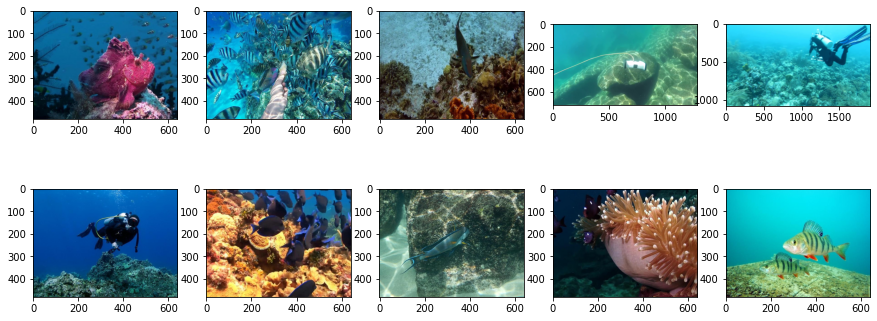

In [115]:
images=os.listdir(img_dir)
images=images[0:10]
im=[]
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
for n in range(10):
    image = cv2.imread(os.path.join(img_dir, images[n]))
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[n].imshow(image)

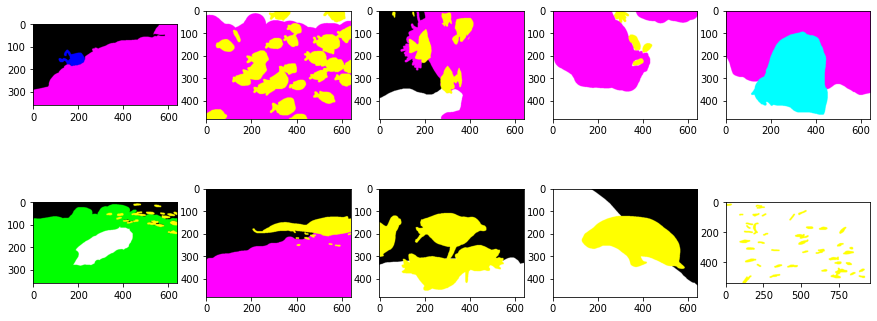

In [116]:
images=os.listdir(mask_dir)
images=images[0:10]
im=[]
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
for n in range(10):
    image = cv2.imread(os.path.join(mask_dir, images[n]))
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[n].imshow(image)

In [6]:
c=[(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(1,1,1),(0,1,1),(0,0,0)]
class ImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images=os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg",".bmp"))
        image=Image.open(img_path)
        mask=Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        mp=nn.ReflectionPad2d(92)
        img=image.numpy()
        imgt=torch.tensor([img])
        imgt=mp(imgt)
        mask=mask.numpy()
        mask=np.transpose(mask, (1, 2, 0))
        m=[]
        for i in c:
            maskt = cv2.inRange(mask, i, i)
            maskt=(maskt!=0)
            maskt=maskt.astype('uint8')
            m.append(maskt)
        m=np.array(m)
        mask=m
        mask=torch.from_numpy(mask)
        nm=transforms.Normalize((0, 0, 0), (1, 1,1),inplace=True)
        return nm(imgt[0]), mask

In [7]:
image_transform=transforms.Compose([transforms.Resize((388,388)),transforms.ToTensor()])
mask_transform=transforms.Compose([transforms.Resize((388,388)),transforms.ToTensor()])
fi="./Assignment 1 - Semantic Segmentation - Dataset/train_val/images"
fm="./Assignment 1 - Semantic Segmentation - Dataset/train_val/masks"
train=ImageDataset(fi,fm,transform=image_transform,target_transform=mask_transform)

(572, 572, 3)


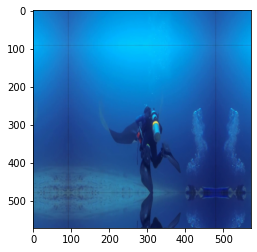

In [8]:
im,mask=train[110]
img=im.numpy()
img=np.transpose(img, (1, 2, 0))
print(img.shape)
plt.imshow(img)

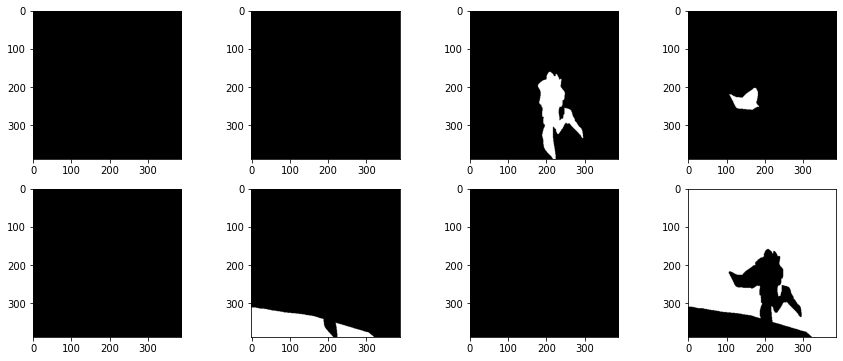

In [9]:
mask=mask.numpy()
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(mask):
    axs[n].imshow(i,cmap="gray")

In [10]:
len(train)
val_size = int(0.2*len(train))
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(1220, 305)

In [11]:
train_loader = torch.utils.data.DataLoader(train_ds,batch_size=16, num_workers=2,pin_memory=True,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, num_workers=2,pin_memory=True,shuffle=True)

In [12]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)

In [96]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=8, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                skip_connection = transforms.CenterCrop(size=x.shape[2:])(skip_connection)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [97]:
img=im.numpy()
imgt=torch.tensor([img])
model = UNet()
model.apply(initialize_weights)
preds = model(imgt)
preds.shape

torch.Size([1, 8, 388, 388])

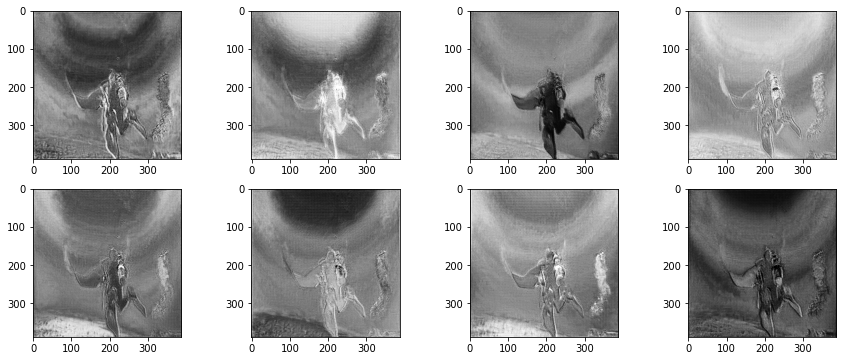

In [98]:
preds = torch.sigmoid(preds)
preds=preds[0].detach().numpy()
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(preds):
    axs[n].imshow(i,cmap="gray")

In [99]:
def validate(loader, model, loss_func,device="cuda"):
    model.eval()
    l=[]
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.float().to(device)
            predictions = model(x)
            preds = torch.sigmoid(predictions)
            preds = (preds > 0.4).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            predictions=predictions.view(-1)
            y=y.view(-1)
            loss = loss_fn(predictions, y)
            loss=loss.to("cpu")
            loss=loss.numpy()
            loss=loss.reshape(1)
            l.append(loss[0])
    l=np.array(l)
    model.train()
    acc=(num_correct/num_pixels).to("cpu").numpy().reshape(1)
    return np.mean(l),acc[0]

In [100]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def train_fn(loader, val_loader,model,loss_fn, scaler):
    opt_func = torch.optim.Adam
    optimizer = opt_func(model.parameters(), lr=0.001)
    s = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2,gamma=0.90)
    tl=[]
    vl=[]
    tcc=[]
    vcc=[]
    tloss,tacc=validate(loader,model,loss_fn)
    vloss,vacc=validate(val_loader,model,loss_fn)
    tl.append(tloss)
    vl.append(vloss)
    tcc.append(tacc)
    vcc.append(vacc)
    for epochs in range(50):
      loop = tqdm(loader)
      for batch_idx, (data, targets) in enumerate(loop):
          data = data.to(device=DEVICE)
          targets = targets.float().to(device=DEVICE)

          # forward
          with torch.cuda.amp.autocast():
              predictions = model(data)
              predictions=predictions.view(-1)
              targets=targets.view(-1)
              loss = loss_fn(predictions, targets)

          # backward
          optimizer.zero_grad()
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

          # update tqdm loop
          loop.set_postfix(loss=loss.item())
      s.step()
      tloss,tacc=validate(loader,model,loss_fn)
      vloss,vacc=validate(val_loader,model,loss_fn)
      tl.append(tloss)
      vl.append(vloss)
      tcc.append(tacc)
      vcc.append(vacc)
    return tl,vl,tcc,vcc

In [101]:
model = Unet().to(DEVICE)
model.apply(initialize_weights)
loss_fn = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()


In [102]:
tl,vl,tcc,vcc=train_fn(train_loader, val_loader,model,loss_fn,scaler)

100%|██████████| 77/77 [02:30<00:00,  1.95s/it, loss=0.13]  


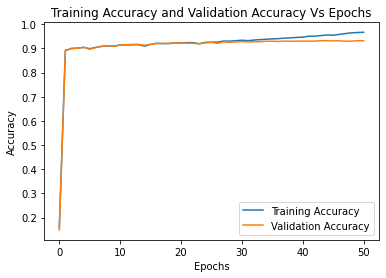

In [122]:
plt.plot(tcc)
plt.title("Training Accuracy and Validation Accuracy Vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(vcc)
plt.legend(["Training Accuracy","Validation Accuracy"])

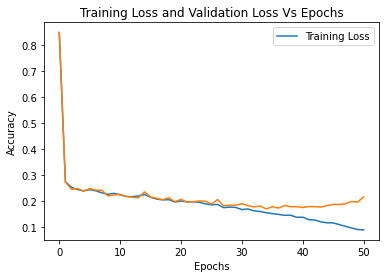

In [123]:
plt.plot(tl)
plt.title("Training Loss and Validation Loss Vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Loss","Validation Loss"])
plt.plot(vl)

(572, 572, 3)


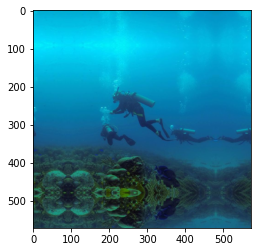

In [106]:
im2,mask2=train[10]
img=im2.numpy()
img=np.transpose(img, (1, 2, 0))
print(img.shape)
plt.imshow(img)

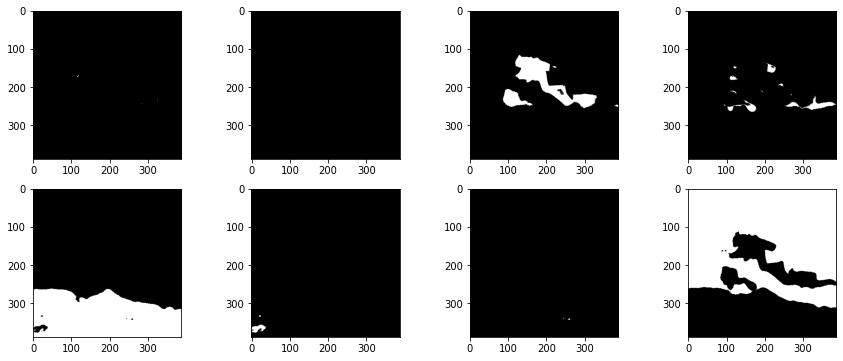

In [109]:
img1,mask1=train[10]
img1=img1.numpy()
imgt=torch.tensor([img1])
imgt=imgt.to(DEVICE)
pred1=model(imgt)
pred1 = torch.sigmoid(pred1)
pred1=pred1.to("cpu")
pred1=pred1[0].detach().numpy()
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=np.argmax(pred1,axis=0)
for n, i in enumerate(pred1):
    i=i*(m==n)
    i=i>np.mean(i)
    axs[n].imshow(i,cmap="gray")

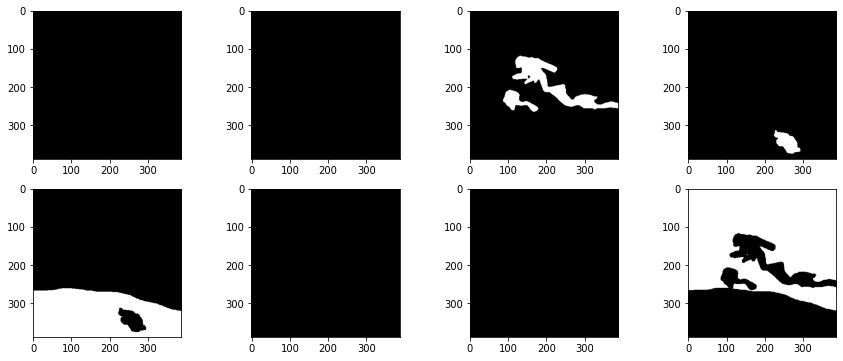

In [108]:
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(mask1):
    axs[n].imshow(i,cmap="gray")

In [ ]:
It took a lot of time to train and it was not possible in the cpu so we took the help of outer gpu in the form of kaggle and it was overfitting after the around 42 epoces